# parsing configuration file

In [1]:
import configparser
confParser = configparser.ConfigParser()

In [2]:
#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())

#--- set dynamic parameters
temp=confParser['parameters']['temperature']

#--- edit list of input files
confParser.set('input files','dump file',''.join([
               'allconf ', #0
              ]))
confParser.set('input files','diffusion file',''.join([
               'Diffusion.dat ', #0
              ]))


conf. file sections: ['parameters', 'flags', 'input files', 'Atomic Radius']


# import libraries

In [37]:
import sys
sys.path.append(confParser['input files']['lib_path'])

#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from functools import reduce
import time
import fnmatch
from scipy.optimize import curve_fit
#
warnings.filterwarnings('ignore')

#--- user modules
import LammpsPostProcess as lp
import LammpsPostProcess2nd as lpp
import utilityy as utll
import utility as utl
from utility import *
import imp
imp.reload(lp)
imp.reload(lpp)
imp.reload(utl)
imp.reload(utll)

<module 'utilityy' from '../../HeaDef/postprocess/utilityy.py'>

In [4]:
class Symbols:
    def __init__(self):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=[10,10,10,12,12,12,10]
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

class Legends:
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs

DRAW_FRAME=(0.23,0.08,0.12,0.07,0.01)
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    


# Dump File

In [38]:
!rm -r dumpFile;mkdir dumpFile

#--- fetch parameters
path = confParser['input files']['input_path']
indx = confParser['input files']['fileIndex']
dumpFile = '%s/%s'%(path,confParser['input files']['dump file'].split()[int(indx)])
datFile = '%s/%s'%(path,confParser['input files']['diffusion file'].split()[int(indx)])
lib_path = confParser['input files']['lib_path']
outpt = 'dumpFile/dump.xyz'
outpt_headers = 'dumpFile/calcResults.txt'

#--- parse dump: call ovito
t0=time.time()
!ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 7 $outpt_headers
print('output dump file=%s s'%(time.time()-t0))


#--- parse dump files
print('parsing %s'%(outpt))
lmpData = lp.ReadDumpFile( '%s'%(outpt) ) 
lmpData.GetCords( ncount = sys.maxsize, 
                )
print('time steps:',lmpData.coord_atoms_broken.keys())
display(lmpData.coord_atoms_broken[0].head())

#--- add timescales
lmpData.times = np.loadtxt(datFile)[:,0]

#--- parse headers
lmpData.headers = pd.DataFrame(np.loadtxt(outpt_headers),columns=["Barrier", "Energy", "Step", "Time"])

#--- common neighbor analysis
dumpFile = 'dumpFile/dump.xyz'
outpt = 'dumpFile/neighbors.xyz'
t0=time.time()
!ovitos $lib_path/OvitosCna.py $dumpFile $outpt 1 0
print('output dump file=%s s'%(time.time()-t0))

#--- parse dump files
print('parsing %s'%(outpt))
lmpCna = lp.ReadDumpFile( '%s'%(outpt) ) 
lmpCna.GetCords( ncount = sys.maxsize, 
                )
print('time steps:',lmpCna.coord_atoms_broken.keys())
display(lmpCna.coord_atoms_broken[0].head())


InputFile= ../simulations/NiNatom16KTemp1400K/Run0/allconf
num_frames= 3
frame=0
frame=1
frame=2
output dump file=0.3080165386199951 s
parsing dumpFile/dump.xyz
reached end of file!
time steps: dict_keys([])


KeyError: 0

In [16]:
np.loadtxt(datFile).shape

(101, 4)

In [6]:
def AddRndStrs(df):
    df['sxx']=np.random.normal(size=len(df))
    df['syy']=np.random.normal(size=len(df))
    df['szz']=np.random.normal(size=len(df))

#--- add random stress
#list( map(lambda x:AddRndStrs(lmpData.coord_atoms_broken[x]),lmpData.coord_atoms_broken.keys()) )


# Displacements

In [21]:
def WrapperDisp(lmpData,reference_frames,current_frames):
    '''
    invoke disp analysis in ovito
    '''
    #--- split dump file
    for ii0, ii in zip(reference_frames,current_frames):
        atom_current = lp.Atoms(**lmpData.coord_atoms_broken[ii])
        atom_reference = lp.Atoms(**lmpData.coord_atoms_broken[ii0])
        box  = lp.Box( BoxBounds = lmpData.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[ii0], AddMissing = np.array([0.0,0.0,0.0] ))
        lpp.WriteDumpFile(atom_current, box).Write('disp/dump_curr.xyz', itime = ii,
                 attrs=['id', 'type','x', 'y', 'z'],
                 fmt='%i %i %15.14e %15.14e %15.14e')
        lpp.WriteDumpFile(atom_reference, box0).Write('disp/dump_ref.xyz', itime=ii0,
                 attrs=['id', 'type','x', 'y', 'z'],
                 fmt='%i %i %15.14e %15.14e %15.14e')
    #    os.system('tar czf dump.gz dump.xyz')
        fileCurr = 'disp/dump_curr.xyz'
        fileRef = 'disp/dump_ref.xyz'
        output = 'disp/disp.%s.xyz'%ii
        #--- load to ovito
        os.system('ovitos %s/OvitosCna.py %s %s 2 8 %s'%(lib_path,fileCurr,output,fileRef))
        #--- concat
        os.system('cat %s >> disp/disp.xyz;rm %s'%(output,output))
        
        
        

!mkdir disp

#--- fetch parameters
lib_path = confParser['input files']['lib_path']
outpt = 'disp/disp.xyz'
!rm $outpt

current_frames = np.array(list(lmpData.coord_atoms_broken.keys())) #[::2] #--- ignore half steps
current_frames.sort()
print('current_frames=',current_frames)
#--- reference
reference_frames = [current_frames[0]]*len(current_frames)
print('reference_frames=',reference_frames)
    
    
#--- call ovito
WrapperDisp(lmpData,reference_frames,current_frames)


#--- parse dump files
print('parsing %s'%(outpt))
lmpDisp = lp.ReadDumpFile( 'disp/disp.xyz' )
lmpDisp.GetCords( ncount = sys.maxsize )
display(lmpDisp.coord_atoms_broken[0].head())


mkdir: cannot create directory ‘disp’: File exists
current_frames= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201]
reference_frames= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= d

id  type          x          y          z  DisplacementX  DisplacementY  \
0   1     1  14.529185  10.993651  42.813454            0.0            0.0   
1   2     1  30.439087  32.206852  33.974621            0.0            0.0   
2   3     1  32.206852  35.742386  49.884525            0.0            0.0   
3   4     1  46.348988  37.510155  51.652290            0.0            0.0   
4   5     1  39.277920   5.690350  41.045689            0.0            0.0   

   DisplacementZ  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

In [22]:
#--- refframe = current_frame - 1
#--- reference
!rm -r disp;mkdir disp
print('current_frames=',current_frames)
reference_frames = np.concatenate([[0],current_frames[:-1]])
print('reference_frames=',reference_frames)
    
    
#--- call ovito
WrapperDisp(lmpData,reference_frames,current_frames)


#--- parse velocity
print('parsing %s'%(outpt))
lmpVel = lp.ReadDumpFile( 'disp/disp.xyz' )
lmpVel.GetCords( ncount = sys.maxsize )
display(lmpVel.coord_atoms_broken[0].head())


current_frames= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201]
reference_frames= [  0   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34

InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= disp/dump_curr.xyz
num_frames= 1
frame=0
InputFile= d

id  type          x          y          z  DisplacementX  DisplacementY  \
0   1     1  14.529185  10.993651  42.813454            0.0            0.0   
1   2     1  30.439087  32.206852  33.974621            0.0            0.0   
2   3     1  32.206852  35.742386  49.884525            0.0            0.0   
3   4     1  46.348988  37.510155  51.652290            0.0            0.0   
4   5     1  39.277920   5.690350  41.045689            0.0            0.0   

   DisplacementZ  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

In [299]:
# times = list(lmpDisp.coord_atoms_broken.keys())
# times.sort()
# times = times[1:]
# count=0
# xsum_concat=np.array([0,0,0])
# for itime in times:
#     filtr = lmpCna.coord_atoms_broken[itime-1]['StructureType'] == 0.0
#     lmpCna.coord_atoms_broken[itime-1][filtr]
#     xsum = -np.array(lmpVel.coord_atoms_broken[itime][filtr]
#                     [['DisplacementX','DisplacementY','DisplacementZ']].sum())
#     xsum_concat = np.c_[xsum_concat,xsum]
#     count += 1
# xsum_concat = xsum_concat.T

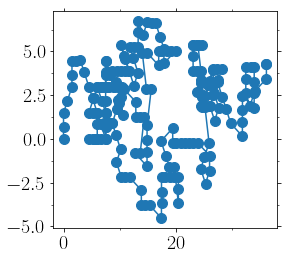

<AxesSubplot:>

In [300]:
xv = xsum_concat.cumsum(axis=0)
utl.PltErr(xv[:,0],xv[:,1])

In [301]:
itime=0
filtr = lmpCna.coord_atoms_broken[itime]['StructureType'] == 0.0
rc = np.array(lmpData.coord_atoms_broken[itime][filtr]
                [['x','y','z']].mean())


In [302]:
!rm void.xyz
for itime in range(xv.shape[0]):
    sfile=open('void.xyz','a')
    utl.PrintOvito(pd.DataFrame(np.c_[xv[itime,:]+rc].reshape(1,3),columns=['x','y','z']), 
                   sfile, 'itime=%s'%itime, attr_list=['x', 'y', 'z'])

In [283]:
lmpDisp.coord_atoms_broken.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201])

In [290]:
def unwrapped(key0,key1):
    times = list(lmpDisp.coord_atoms_broken.keys())
    times.sort()
    x = np.concatenate([list(map(lambda x:lmpVel.coord_atoms_broken[x][key0],times))],axis=0).T
    x=x.cumsum(axis=1)
    x= (x.T + np.array(lmpVel.coord_atoms_broken[0][key1])).T
    return x

x=unwrapped('DisplacementX','x')
y=unwrapped('DisplacementY','y')
z=unwrapped('DisplacementZ','z')

times = list(lmpDisp.coord_atoms_broken.keys())
times.sort()
count=0
#xsum_concat=np.array([0,0,0])
for itime in times:
    filtr = lmpCna.coord_atoms_broken[itime]['StructureType'] == 0.0
    xsum = np.array([x[:,itime][filtr].mean(), y[:,itime][filtr].mean(), z[:,itime][filtr].mean()])
    xsum_concat = xsum.copy() if itime == 0 else np.c_[xsum_concat,xsum]
    count += 1
xsum_concat = xsum_concat.T
xsum_concat

!rm void.xyz
for itime in range(xsum_concat.shape[0]):
    sfile=open('void.xyz','a')
    utl.PrintOvito(pd.DataFrame(np.c_[xsum_concat[itime,:]].reshape(1,3),columns=['x','y','z']), 
                   sfile, 'itime=%s'%itime, attr_list=['x', 'y', 'z'])

In [293]:
lmpVel.coord_atoms_broken[55]['DisplacementX'].min()

-1.8501816

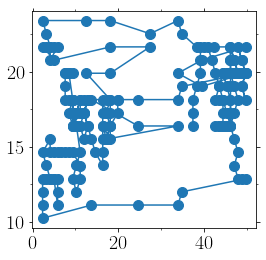

<AxesSubplot:>

In [287]:
utl.PltErr(xsum_concat[:,0],xsum_concat[:,1])

## msd vs. time

mkdir: cannot create directory ‘msd’: File exists


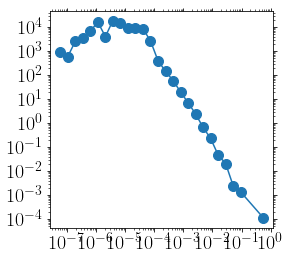

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 200 and the array at index 1 has size 201

In [30]:
class MsDisp:
    
    def __init__(self, lmpDisp, lmpVel, lmpCna, filtr):
        '''
        returns mean-squared displacements
        '''
        self.disp = lmpDisp.coord_atoms_broken
        self.veloc = lmpVel.coord_atoms_broken
        self.cna = lmpCna.coord_atoms_broken
        
        self.times = list(lmpDisp.coord_atoms_broken.keys())
        self.times.sort()
        
        self.filtr=filtr
    def Get(self,LOG=False):
        '''
        returns msd (no temporal window)
        '''
        if not LOG: #---  mean
            msd = list(map(lambda x:(self.disp[x]['DisplacementX']**2+\
                         self.disp[x]['DisplacementY']**2+\
                         self.disp[x]['DisplacementZ']**2).mean(),
                    self.times))
        else: #--- geometric mean
            msd = list(map(lambda x:10**((np.log10(self.disp[x]['DisplacementX']**2+\
                         self.disp[x]['DisplacementY']**2+\
                         self.disp[x]['DisplacementZ']**2)).mean()),
                    self.times))
        return np.array(msd)
        
    def GetPdfJumps(self):
        '''
        pdf's of jumps
        '''
        for itime in self.times:
            df=self.veloc[itime]
            if itime == 0:
                df_concat = np.c_[df[['DisplacementX','DisplacementY','DisplacementZ']]]
            else:
                df_concat = np.concatenate([df_concat,df[['DisplacementX','DisplacementY','DisplacementZ']]],axis=0) 
        df_abs = np.abs(df_concat.flatten())
        filtr = df_abs > 0.0
        
        hist, bin_edges, err = utl.GetPDF(df_abs[filtr],n_per_decade=4)
        utl.PltErr(bin_edges,hist, yerr=err,
                  yscale='log',
                   xscale='log',
        #           ylim=(1e-6,1e4)
                  )
        #
        with open('msd/event_jumps.txt','w') as fp:
            np.savetxt(fp,np.c_[bin_edges,hist,err],header='bin_edges hist err')

        
    def WindowAverage(self,ttime,bins_per_decade=4,LOG=False):
        '''
        returnd msd (include temporal windows)
        '''
        for shift in range(1,len(self.times)-1):
    #        shift = 1 #--- time index  shift
            dt = zip(self.times,self.times[shift:]) #--- time tuples
            dt_real = list(map(lambda x: x[1]-x[0], zip(ttime,ttime[shift:]))) #--- real time difference
            if not LOG: #---  mean
                disp = list(map(lambda x: ((self.disp[x[1]]['DisplacementX'][self.filtr]-self.disp[x[0]]['DisplacementX'][self.filtr])**2+\
                              (self.disp[x[1]]['DisplacementY'][self.filtr]-self.disp[x[0]]['DisplacementY'][self.filtr])**2+\
                              (self.disp[x[1]]['DisplacementZ'][self.filtr]-self.disp[x[0]]['DisplacementZ'][self.filtr])**2).mean(),
                    zip(self.times,self.times[shift:])))
            else:
                disp = list(map(lambda x: 10**((np.log10((self.disp[x[1]]['DisplacementX'][self.filtr]-self.disp[x[0]]['DisplacementX'][self.filtr])**2+\
                              (self.disp[x[1]]['DisplacementY'][self.filtr]-self.disp[x[0]]['DisplacementY'][self.filtr])**2+\
                              (self.disp[x[1]]['DisplacementZ'][self.filtr]-self.disp[x[0]]['DisplacementZ'][self.filtr])**2)).mean()),
                    zip(self.times,self.times[shift:])))
            
#            print(np.c_[dt_real,disp].shape)
            if shift == 1:
                tr_mat=np.c_[dt_real,disp]
            else:    
                tr_mat = np.concatenate([tr_mat,np.c_[dt_real,disp]],axis=0)
                
                
                
        #--- binning
        xmin = 0.99*tr_mat[:,0].min()
        xmax = 1.01*tr_mat[:,0].max()
        n_decades = int(np.ceil(np.log10(xmax/xmin)))
        bins = np.logspace(np.log10(xmin),np.log10(xmax),n_decades*bins_per_decade)
        #
        ysum, edges = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1])
        ysum_sq, edges = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1]*tr_mat[:,1])
        xsum, edges = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,0])
        count, edges = np.histogram(tr_mat[:,0],bins=bins)
        #
        filtr = count > 1
        ysum = ysum[filtr]
        ysum_sq = ysum_sq[filtr]
        xsum = xsum[filtr]
        count = count[filtr]
        assert not np.any(count == 0), 'incerease bin size!'
        #
        ysum_sq /= count
        ysum /= count
        xsum /= count
        ysum_sq -= (ysum * ysum)
#        assert not np.any(ysum_sq < 0.0), 'print %s'%ysum_sq
        
        return np.c_[xsum,ysum,(ysum_sq/count)**0.5]
    
    def VacancyDynamics(self):
        '''
        return xyz coordinates associated with vacancy 
        '''
        #--- unwrapped coordinates
        times = self.times[1:]
        xsum_concat=np.array([0,0,0])
        for itime in times:
            filtr = self.cna[itime-1]['StructureType'] == 0.0 #--- neighboring atoms
            xsum = -np.array(self.veloc[itime][filtr] #--- disp
                            [['DisplacementX','DisplacementY','DisplacementZ']].sum())
            xsum_concat = np.c_[xsum_concat,xsum]
        xsum_concat = xsum_concat.T
        xv = xsum_concat.cumsum(axis=0) #--- integrate
#        utl.PltErr(xv[:,0],xv[:,1])
        #--- add initial position
        itime=0
        filtr = self.cna[itime]['StructureType'] == 0.0
        rc = np.array(self.veloc[itime][filtr]
                        [['x','y','z']].mean())
        #--- print
        try:
            !rm msd/void.xyz
        except:
            pass
        for itime in range(xv.shape[0]):
            sfile=open('msd/void.xyz','a')
            utl.PrintOvito(pd.DataFrame(np.c_[xv[itime,:]+rc].reshape(1,3),columns=['x','y','z']), 
                       sfile, 'itime=%s'%itime, attr_list=['x', 'y', 'z'])
    

!mkdir msd
msd = MsDisp( lmpDisp, lmpVel, lmpCna,
              np.ones(lmpDisp.coord_atoms_broken[0].shape[0],dtype=bool) #--- filter 
            )
#
msd.GetPdfJumps() #--- jump distributions
#--- vacancy
msd.VacancyDynamics()
#
ans = msd.WindowAverage(lmpData.headers['Time'],bins_per_decade=4,LOG=False) #---msd
ans_logAveraged = msd.WindowAverage(lmpData.headers['Time'],bins_per_decade=4,LOG=True)
#
#
with open('msd/msd.txt','w') as fp:
    np.savetxt(fp,ans,header='t\tmsd\terr')
#
with open('msd/msd_logAveraged.txt','w') as fp:
    np.savetxt(fp,ans_logAveraged,header='t\tmsd\terr')
#
with open('msd/event_times.txt','w') as fp:
    np.savetxt(fp,lmpData.times,header='t')
#
with open('msd/timeseries.txt','w') as fp:
    np.savetxt(fp,np.c_[lmpData.headers],header='Barrier Energy Step Time')
    
#--- filter based on atom types
# types = list(set(lmpDisp.coord_atoms_broken[0]['type']))
# for itype in types:
#     filtr = lmpDisp.coord_atoms_broken[0]['type'] == itype
#     msd = MsDisp( lmpDisp, lmpVel,
#               filtr #--- filter 
#             )
#     ans = msd.WindowAverage(lmpData.times,bins_per_decade=4)
#     #--- print
#     with open('msd/msd_type%s.txt'%itype,'w') as fp:
#         np.savetxt(fp,ans,header='t\tmsd\terr')
#     with open('msd/event_times_type%s.txt'%itype,'w') as fp:
#         np.savetxt(fp,lmpData.times,header='t')



In [27]:
lmpData.headers

Barrier     Energy   Step          Time
0      0.000 -59529.024    0.0  0.000000e+00
1      1.783 -59527.240    0.5  7.243000e-08
2      0.000 -59529.023    1.0  7.243000e-08
3      1.783 -59527.240    1.5  8.313000e-08
4      0.000 -59529.024    2.0  8.313000e-08
..       ...        ...    ...           ...
196    0.000 -59529.024   98.0  2.051000e-06
197    1.783 -59527.240   98.5  2.051000e-06
198    0.000 -59529.023   99.0  2.051000e-06
199    1.783 -59527.240   99.5  2.097000e-06
200    0.000 -59529.024  100.0  2.097000e-06

[201 rows x 4 columns]

In [34]:
lmpData.coord_atoms_broken.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201])

mkdir: png: File exists


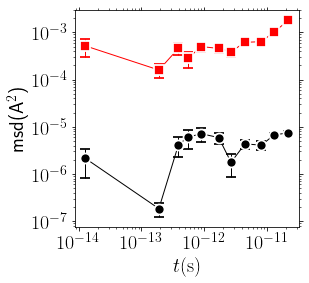

<AxesSubplot:xlabel='$t\\mathrm{(s)}$', ylabel='msd(A$^2$)'>

In [21]:
!mkdir png
symbols=utl.Symbols()

# ans=ans_tot
ax=utl.PltErr(ans_logAveraged[:,0],ans_logAveraged[:,1],
           yerr=ans_logAveraged[:,2],
           attrs=symbols.GetAttrs(count=0),
           Plot=False,
          )

ax=utl.PltErr(ans[:,0],ans[:,1],
           yerr=ans[:,2],
           ax = ax,
           attrs=symbols.GetAttrs(count=1),
           Plot=False,
          )
utl.PltErr(None,#lmpData.times[1:],
           None, #msd.Get()[1:],
          xscale='log',
          yscale='log',
           attrs={'fmt':'-'},
           ax=ax,
#           ylim=(1e-4,1e-1),
           xstr=r'$t\mathrm{(s)}$',
           ystr=r'msd(A$^2$)',
           title='png/msd.png'
          )

## arrhenius law

mkdir: png: File exists
ensemble average


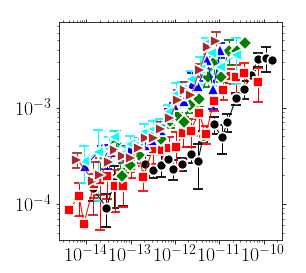

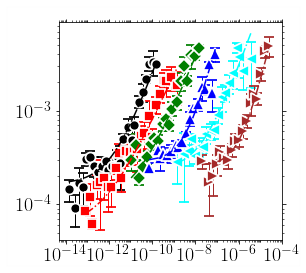

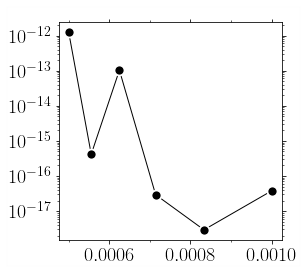

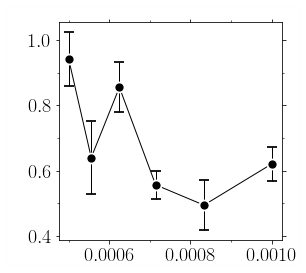

In [143]:
class Temperature:
    
    def __init__(self,temp_range,nrun,verbose=False):
        self.temps =  temp_range
        self.nrun = nrun
        t,r=np.meshgrid(self.temps,np.arange(nrun),indexing='ij')
        self.temps_runs = np.array(list(zip(t.flatten(),r.flatten())))
        self.verbose = verbose
        
    def Parse(self,dirs):
#         print('dirs:',dirs)
        self.data=list(map(lambda x:np.loadtxt(x,ndmin=2),dirs))
        if self.verbose:
            list(map(lambda x:print('Parsing: data.shape is',x.shape),self.data))
#        print('np.array(self.data):',np.array(self.data))

        
    def Plot(self,**kwargs):
#        print(list(self.temps_runs))
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )
        for data, temp_run, count in zip(self.data,self.temps_runs,range(len(self.data))): 
            temp = temp_run[0]
            try:
                utl.PltErr(data[:,0],data[:,1],
                       yerr=data[:,2],
                       ax = self.ax,
                       attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp),
                       Plot=False,
                      )
            except:
                continue
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   DrawFrame=DRAW_FRAME,
                legend=legends.Get(),
                   **kwargs
                  )
        
    def EnsAverage(self,log_scale=False):
        kount = 0
        self.data_averaged = {} #np.zeros(len(self.temps))
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun]
            if self.verbose:
                print('data.shape:',np.array(data).shape)
#             print('np.array(data):',np.array(data))
#             pdb.set_trace()
    
            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
    
            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
            self.data_averaged[ temp ] = self.hist(data,log_scale)
            kount += self.nrun

    def hist(self,data,log_scale):
        n_thresh = 1
            #--- average
        xdata = data[:,0]
        ydata = data[:,1]
        xmin = np.floor(np.log10(xdata).min())
        xmax = np.ceil(np.log10(xdata).max())
        n_decades = int((xmax - xmin))
        bins = np.logspace(xmin,xmax,n_decades*6)
        #
        count, _ = np.histogram(xdata,bins=bins)
        xsum, _  = np.histogram(xdata,bins=bins,weights=xdata)
        weights = ydata if not log_scale else np.log10(ydata)
        ysum, _  = np.histogram(xdata,bins=bins,weights=weights)
        ysum_sq, _  = np.histogram(xdata,bins=bins,weights=weights*weights)
        #
        xsum = xsum[count>n_thresh]
        ysum = ysum[count>n_thresh]
        ysum_sq = ysum_sq[count>n_thresh]
        count = count[count>n_thresh]
        #
        xsum /= count
        ysum /= count
        ysum_sq /= count
        std = np.sqrt((ysum_sq - ysum * ysum)/count)
        if log_scale:
            ysum = 10 ** ysum
            std = 0.5 * ysum * (1+2*std*np.log(10))
        return np.c_[xsum,ysum,std]
        
        
#            utl.PltErr(xsum,ysum,ax=self.ax)
            

    def PlotAverage(self,**kwargs):
#        print(list(self.temps_runs))
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5))
        for temp, count in zip(self.temps,range(len(self.temps))): 
            data = self.data_averaged[ temp ]
            utl.PltErr(data[:,0],data[:,1],
                   yerr=data[:,2],
                   ax = self.ax,
                   attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp,nevery=1),
                   Plot=False,
                  )

        utl.PltErr(None,
                   None, 
                   ax=self.ax,
                   Plot=False,
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
        
        
    def func2nd(self,x,x0,y0,c0,alpha):
        return y0+c0*(x/x0)**alpha
#     def func2nd(self,x,y0,m0):
#         return y0+m0*x

    def Fit(self,Plot=None,shift = False,SIGMA=False,plotAttrs=None,**kwargs):
        self.Diffusion = {}
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5))

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for temp, count in zip(self.temps,range(len(self.temps))): 
            smat = self.data_averaged[ temp ] if self.nrun > 1 else self.data[count]

            xdata=smat[:,0]
            ydata=smat[:,1]
            yerr = smat[:,2]
            sigma = yerr if SIGMA else None
            popt, pcov = curve_fit(self.func2nd, xdata, ydata,
                                   sigma = sigma,
                                   **kwargs
                                    )
            #--- uncertainties
            if self.verbose:
                print('Temp=%s,x0,y0,c0,alpha'%temp,list(popt),pcov)
            alpha=popt[3]
            err_alpha = pcov[3,3]**0.5
            c0=popt[2]
            dc = pcov[2,2]**0.5
            tau=popt[0]
            dtau=pcov[0,0]**0.5
#             self.Diffusion[temp] = [pref*c0/tau,pref*c0/tau,pref*c0/tau]
            self.Diffusion[temp] = [pref*c0/(tau)**alpha, pref*(c0+dc)/(tau-dtau)**alpha, 
                                    pref*(c0-dc)/(tau+dtau)**alpha]
            self.exponent[temp] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                #---fit
                xdata_shift = xdata*20**count if shift else xdata
                utl.PltErr(xdata_shift,
                                self.func2nd(xdata,*popt),
                                attrs={'fmt':'-.r','color':symbols.colors[count%7]},
                           Plot=False,ax=ax)
                #--- points
                utl.PltErr(xdata_shift,
                           ydata,
                           yerr=yerr,
                           attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp,fmt='.'),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
#                        legend=legends.Get(),
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs
                      )

    def PlotDiff(self,**kwargs):
        symbols=utl.Symbols()
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.Diffusion[x][0],self.temps)),
                   yerr=list(map(lambda x:(self.Diffusion[x][1]-self.Diffusion[x][2])/2,self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def PlotExponent(self,**kwargs):
        symbols=utl.Symbols()
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.exponent[x][0],self.temps)),
                   yerr=list(map(lambda x:(self.exponent[x][1]-self.exponent[x][2])/2,self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    #--- temp object
    temp = Temperature(
        [1000,1200,1400,1600,1800,2000],8,
#        np.arange(1000,1440,80),1,
#        verbose = True,
                     )
    #
    #--- parse data
    temp.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/msd.txt'%(x[0],x[1]),
#    temp.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
                         temp.temps_runs ))
              )
    #
    #--- plot
#     print('single realizations')
#     temp.Plot(**{
#                   'xscale':'log',
#                   'yscale':'log',
#                    'attrs':{'fmt':'-'},
# #                   'xlim':(1e-10,1e-3),
# #                   'ylim':(1e-4,1e-1),
# #                   'xstr':r'$t\mathrm{(s)}$',
# #                   'ystr':r'msd(A$^2$)',
#                    'title':'png/msd_temp_ni.png',
#         'bbox_to_anchor':(0.01,0.3,0.5,0.5)
#     })
    #
    #--- plot average
    #
    if temp.nrun > 1:
        print('ensemble average')
        temp.EnsAverage(log_scale=False)
        temp.PlotAverage(**{
                  'yscale':'log',
                  'xscale':'log',
#                   'xlim':(1e-10,1e-3),
#                   'ylim':(1e-4,1e-1),
#                     'xstr':r'$t\mathrm{(s)}$',
#                   'ystr':r'msd(A$^2$)',
                   'title':'png/msd_temp_cantor.png',
        })
    #
    #--- fit
    #
    temp.Fit(Plot=True,
             shift=True,
#             bounds=([0, 0, 0,0.999], [1e-2, 1e-3, 1,1.001]),
#             p0=[2.450192558293684e-08, 0.00023822488904874157, 0.9999977703994274, 0.9991059679876155],
            p0=[[1e-08, 1e-4, 1e2, 1.0]],
             SIGMA=True, #--- comment for ni
             plotAttrs={'yscale':'log',
                  'xscale':'log',
#                   'xlim':(1e-10,1e-3),
#                   'ylim':(1e-4,1e-1),
#                     'xstr':r'$t\mathrm{(s)}$',
#                   'ystr':r'msd(A$^2$)',
                        'ndecade_x':2,
#                    'bbox_to_anchor':(0.01,0.3,0.5,0.5),
                   'title':'png/msd_temp_cantor_fit.png'},
            )
    temp.PlotDiff(**{
                  'yscale':'log',
#                   'xlim':(1e-10,1e-3),
#                   'ylim':(1e-4,1e-1),
#                   xstr=r'$1/T(K^{-1})$',
#                   ystr=r'$D(m^2/s)$',
                    'title':'png/D_temp_cantor.png',
                    }
                )

    temp.PlotExponent(**{
#                  'yscale':'log',
#                   'xlim':(1e-10,1e-3),
#                   'ylim':(.5,1.1),
#                   xstr=r'$1/T(K^{-1})$',
#                   ystr=r'$D(m^2/s)$',
                    'title':'png/alpha_temp_cantor.png',
                    }
                )
    


### per type

mkdir: cannot create directory ‘png’: File exists
ensemble average: type 1
ensemble average: type 2
ensemble average: type 3
ensemble average: type 4
ensemble average: type 5


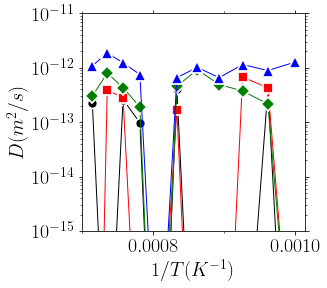

In [26]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    ax = utl.PltErr(None,None,Plot=False)
    symbols=utl.Symbols()
    legends = Legends()
    legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
 
                       
    ntype = 5
    for itype in range(1,ntype+1):
        temp = Temperature(#[1000],3
                           list(map(int,np.linspace(1000,1400,11))),3
                          )
        temp.Parse( list(map(lambda x:'CantorNatom16KTemp%sK_ensemble/Run%s/msd/msd_type%s.txt'%(x[0],x[1],itype),
                            temp.temps_runs ))
                  )
        #
  #      print('single realizations')
  #      temp.Plot()
        #
        print('ensemble average: type %s'%itype)
        temp.EnsAverage()
#         temp.PlotAverage()
#         #
        temp.Fit(#Plot=True,
        #         verbose=True
        )
#         temp.PlotDiff()
        
        #--- plot
        utl.PltErr(1/np.array(list(temp.Diffusion.keys())),
                   list(map(lambda x:temp.Diffusion[x],list(temp.Diffusion.keys()))),
                       Plot=False,
                   ax=ax,
                   attrs=symbols.GetAttrs(count=(itype-1)%7,label=r'$%s$'%temp),
                 )
    utl.PltErr(None,None,
               ax=ax,
               yscale='log',
               ylim=(1e-15,1e-11),
              xstr=r'$1/T(K^{-1})$',
              ystr=r'$D(m^2/s)$',
              )

## wait times

mkdir: png: File exists


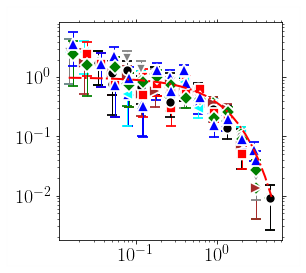

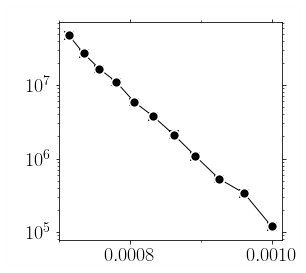

In [228]:
class Stats(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def PlotWaitTimes(self,scale=False,**kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[indx:indx+self.nrun]
            data = list(map(lambda x:self.GetWaitTimes(x),data))
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            data = np.concatenate(data) #,axis=0)
            rate = 1.0 / data.mean()
            self.mean_rate[temp] = [ rate, rate*(1/len(data)**0.5)]
            if scale:
                data /= data.mean() 
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
            hist, bin_edges, err = utl.GetPDF(data,n_per_decade=6)
            #--- plot
            utl.PltErr(bin_edges,hist,
                          yerr=err,
                   attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp,fmt='.'),
                   ax = self.ax,
                   Plot=False,
                          )
        #
        xhi=self.ax.axis()[1]
        xarr = np.logspace(np.log10(xhi)-2.5,np.log10(xhi),32)
        utl.PltErr( xarr if scale else None,
                   np.exp(-xarr) if scale else None,
                   attrs={'fmt':'-.r','lw':2},
                   ax=self.ax,
                   Plot=False,
                   
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
            
    def PlotAverageRate(self,**kwargs):
#        print(list(self.temps_runs))
#         self.ax = utl.PltErr(None,#ans[:,0],
#                         None,#1e8*ans[:,0],
#                         attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        data = list(map(lambda x:self.mean_rate[ x ][0], self.temps))
        err = list(map(lambda x:self.mean_rate[ x ][1], self.temps))
#             utl.PltErr(data[:,0],data[:,1],
#                    yerr=data[:,2],
#                    ax = self.ax,
#                    attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp),
#                    Plot=False,
#                   )

        utl.PltErr(1.0/np.array(self.temps),
                   data,
                   yerr=err,
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
            
    
    def GetWaitTimes(self,times):
#         times = np.array(np.c_[self.lmpData.headers['Time'].iloc[0::2]].flatten())
        dtt = times[1:]-times[:-1]
        assert not np.any(dtt<0.0)
        filtr = dtt > 0.0
        return dtt[filtr]

    #
    def Barries(self):
        Barrier = self.lmpData.headers['Barrier'].iloc[1::2]        
        hist, bin_edges, err = utl.GetPDF(Barrier,linscale=True,n_per_decade=16)
        utl.PltErr(bin_edges,hist,
                  yerr=err,
                   attrs=symbols.GetAttrs(),
                   #yscale='log',
                   #xscale='log',
                   xstr=r'$\Delta E$',
                   ystr=r'$P(\Delta E)$'
                  )

if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = Stats(
#        [1000,1200,1400,1600,1800,2000],6,
        np.arange(1000,1440,40),1,
        verbose=False
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/event_times.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/event_times.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotWaitTimes(scale=True,
                        **{'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-9,1e-3),
#                   'ylim':(1e-4,2e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                   'title':'png/waitTimes_unscaled_ni.png'},

                       )
    stats.PlotAverageRate(
                **{
#                  'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-9,1e-3),
#                   'ylim':(1e11,1e12), #(1e-5,1e2),
#                           'xstr':r'$1/T$',
#                           'ystr':r'$\lambda$',
                   'title':'png/eventRate_ni.png'},
    
    )
    #stats.Barries()

## jumps

mkdir: png: File exists


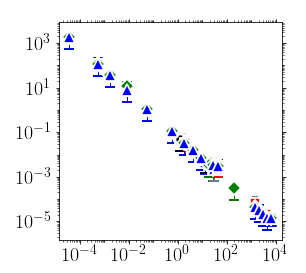

In [27]:
class JumpStats(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def PlotPdf(self,**kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[indx:indx+self.nrun][0]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
#            data = np.array(data).flatten()
            hist = data[:,1]
            bin_edges = data[:,0]
            err = data[:,2]
        #--- plot
            utl.PltErr(bin_edges,hist,
                          yerr=err,
                   attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp,fmt='.'),
                   ax = self.ax,
                   Plot=False,
                          )
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
            

if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = JumpStats(
#        [1000,1200,1400,1600,1800,2000],
        np.arange(1000,1440,40),
        1,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotPdf(scale=False,
                        **{'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-9,1e-3),
#                   'ylim':(1e-3,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_x':2,'ndecade_y':2,
                   'title':'png/jumpsPdf_ni.png'},

                       )

In [7]:
Energy = lmpData.headers['Energy']

## energy

mkdir: png: File exists


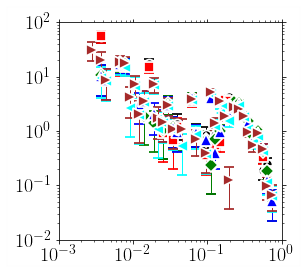

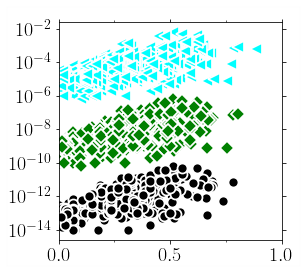

In [133]:
class EnergyStats(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def GetWaitTimes(self,times):
        times = times[0::2]
        dtt = times[1:]-times[:-1]
        assert not np.any(dtt<0.0)
#        filtr = dtt > 0.0
        return dtt#[filtr]
    #
    def PlotPdf(self,**kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        column_energy = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp            
            data = np.concatenate(list(map(lambda x: self.data[x][:,column_energy],range(indx,indx+self.nrun))))
            #--- remove zeros
            data = data[data > 0.0]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
#            data = np.array(data).flatten()
            #--- histogram
            hist, bin_edges, err = utl.GetPDF(data,n_per_decade=16)
        #--- plot
            utl.PltErr(bin_edges,hist,
                          yerr=err,
                   attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp,fmt='.'),
                   ax = self.ax,
                   Plot=False,
                          )
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
    def Scatter(self,nevery=1,**kwargs):
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))

        #
        column_energy = 0
        column_time = 3
        for indx in range(0,len(self.temps),nevery):
            temp = self.temps[indx]
            #--- concat. data for each temp            
            data_energy = np.concatenate(list(map(lambda x: self.GetEnergy(self.data[x][:,column_energy]),
                                                  range(indx,indx+self.nrun))))
            #--- wait_times
            data = self.data[indx:indx+self.nrun]
            data_waitTimes = np.concatenate(list(map(lambda x: self.GetWaitTimes(self.data[x][:,column_time]),
                                                     range(indx,indx+self.nrun))))

            if self.verbose:
                print('data_energy.shape (per temperature):',np.array(data_energy).shape)
                print('data_waitTimes.shape (per temperature):',np.array(data_waitTimes).shape)
            #--- plot scatter
            scale = 100 ** indx
            filtr = data_waitTimes > 0
            utl.PltErr(data_energy[filtr],scale*data_waitTimes[filtr],
                        attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp,fmt='.'),
                        ax = self.ax,
                        Plot=False,
                        )
            #--- plot average
#             nbins = 8
#             count, _=np.histogram(data_energy[filtr],bins=nbins)
#             xsum, _=np.histogram(data_energy[filtr],weights=data_energy[filtr],bins=nbins)
#             ysum, _=np.histogram(data_energy[filtr],weights=data_waitTimes[filtr],bins=nbins)
#             ysum /= count
# #            ysum =10 ** ysum 
#             xsum /= count
#             #---
#             utl.PltErr(xsum,ysum,
#                         attrs=symbols.GetAttrs(count=(indx)%7,label=r'$%s$'%temp,fmt='.'),
#                         ax = self.ax,
#                         Plot=False,
#                         )
        
        
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def GetEnergy(self,slist):
        n=len(slist)
        return slist[1:n:2]
            
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = EnergyStats(
        [1000,1200,1400,1600,1800,2000],8,
#        [1000,1400,1800],8,
#        np.arange(1000,1440,40),1,
#        verbose=True
                     )
    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/timeseries.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/timeseries.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotPdf(scale=False,
                        **{'xscale':'log',
                  'yscale':'log',
                   'xlim':(1e-3,1e0),
                   'ylim':(1e-2,1e2), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
#                        'ndecade_x':2,'ndecade_y':2,
                   'title':'png/BarrierPdf_cantor.png'},

                       )
    stats.Scatter(nevery=2,                        
                **{'xscale':'linear',
                  'yscale':'log',
                   'xlim':(0,1),
#                   'ylim':(1e-3,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_y':2,
                   'title':'png/twVsEnergy_cantor.png',
                  }
)

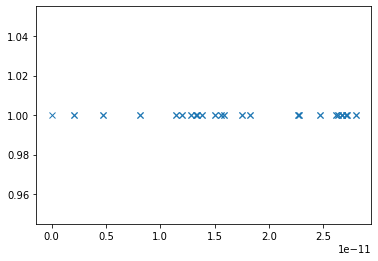

In [11]:
times=lmpData.headers['Time']
plt.plot(times,np.ones(len(times)),'x')

In [26]:
tt=np.array(times.iloc[0:-1:2])
dt=tt[1:]-tt[:-1]

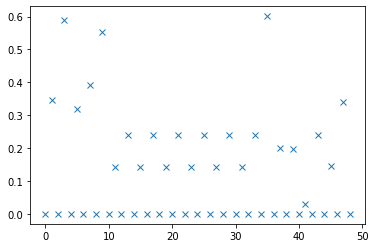

In [27]:
Barrier=lmpData.headers['Barrier']

plt.plot(Barrier,'x')

In [28]:
barrier.shape

(24,)

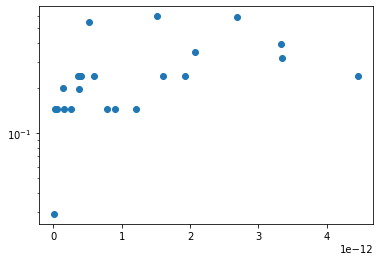

In [33]:
barrier = np.array(Barrier.iloc[1:-1:2])
plt.scatter(dt,barrier[:-1])
plt.yscale('log')

In [34]:
dt

array([2.070e-12, 2.685e-12, 3.344e-12, 3.331e-12, 5.300e-13, 9.000e-13,
       4.000e-13, 1.600e-13, 3.900e-13, 1.210e-12, 6.000e-13, 2.600e-13,
       1.610e-12, 7.800e-13, 4.460e-12, 2.000e-14, 1.930e-12, 1.520e-12,
       1.500e-13, 3.800e-13, 1.000e-14, 3.600e-13, 6.000e-14])

In [35]:
barrier

array([0.347, 0.59 , 0.318, 0.393, 0.552, 0.144, 0.24 , 0.144, 0.24 ,
       0.144, 0.24 , 0.144, 0.24 , 0.144, 0.24 , 0.144, 0.24 , 0.601,
       0.199, 0.196, 0.029, 0.241, 0.146, 0.34 ])

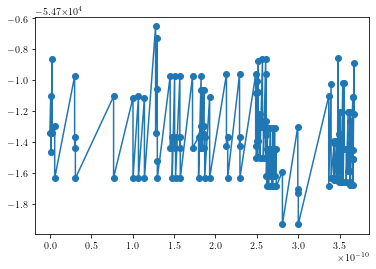

In [95]:
plt.plot(lmpData.headers['Time'],Energy,'-o')